# CS109A - Final Project

# Canvas Group - Final Project # 150

# Group Members - Akhil Srivastava, Han Truong, Yuying Qian

In [31]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from datetime import datetime
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.gofplots import qqplot
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
import pmdarima as pm
from arch import arch_model

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.compat.v1.keras.layers import CuDNNLSTM
from tensorflow.keras.layers import Dropout
from tensorflow.keras import optimizers
from tensorflow.keras.metrics import RootMeanSquaredError
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error

verbose = False

import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)

# Used to parse 'Date Time' column values as pandas DatetimeIndex
dateparse = lambda x: datetime.strptime(x, '%Y-%m-%d')

# Setup Data Pipeline

### Functions to Read and Scale the Data

In [32]:
# Reads Data Downloaded from Bloomberg
def read_bloomberg_data(file_name):
    # Read the file and parse 'DATE' column values as pandas DatetimeIndex
    df = pd.read_csv(file_name, parse_dates=['DATE'], date_parser=dateparse)
    
    df.columns = ['Date','Open','High','Low','Close','Volume']

    # Set 'Date' column as index
    df.set_index('Date', inplace=True)

    # Drop 'Volume' columns as they are not needed
    df = df.drop(['Volume'], 1)
    
    return df

def perform_scaling(df):
     # Create a new dataframe for the scaled values
    df_scaled = df.copy()

    # Dictionary to save the MinMaxScaler scalar objects used for the price transformation
    scalers = {}

    # Scale the data
    for column in df_scaled.columns:
        # Create a new MinMaxScaler scalar object 
        scaler = MinMaxScaler(feature_range = (0, 1))

        # Apply the transformaion on current column
        df_scaled[column] = scaler.fit_transform(df_scaled[[column]])

        # Save the MinMaxScaler object used for price for reverse transformation later
        scalers[column] = scaler
            
    return df_scaled, scalers

### Specify Data Dir Name, Security Names and Data File Names

In [33]:
data_dir = './data/'
security_list = ['Apple Stock', 'Microsoft Stock', 'S&P 500 Index', 'Nasdaq 100 Index']
file_list = ['Apple.csv', 'Microsoft.csv', 'SP500.csv', 'NASDAQ100.csv']

security_list = ['Apple Stock']
file_list = ['Apple.csv']

# Price type to predict
price_type = "Close"

# Declare header and footer prefix and suffix
header_prefix = "\n*************************************************** Processing "
header_suffix = " ************************************************\n"
footer_prefix = "\n********************************************* "
footer_suffix = " Processing Finished *********************************************\n"

### Read and Scale the Data

In [34]:
# Dictionaries to store security price, price diff, log returns, scaled price and scalers
dfs_price = {}
dfs_price_scaled = {}
dfs_price_diff = {}
dfs_log_return = {}
scalers = {}

# Display Summary Statistics, Price Charts and ACF & PACF Plots for Price, Price Difference and Log Returns
for i in range(len(security_list)):
    print("Processing", security_list[i], "...")

    df_price = read_bloomberg_data(data_dir + file_list[i]).dropna()['2010-01-04':]
    df_price_diff = df_price.diff().dropna()
    df_log_returns = np.log(df_price).diff().dropna()

    dfs_price[security_list[i]] = df_price
    dfs_price_scaled[security_list[i]], scalers[security_list[i]] = perform_scaling(df_price)
    dfs_price_diff[security_list[i]] = df_price_diff
    dfs_log_return[security_list[i]] = df_log_returns

Processing Apple Stock ...


# Exploratory Data Analysis

### Functions to Display Summary Statistics, Price, Price Histogram, Normal Q-Q, ACF and PACF Plots

In [35]:
# Displays Summary Statistics and Top and Bottom Rows
def describe_and_peek(df, security_name):
    print("\nNumber of observations:", len(df.index), "\n")    
    print(security_name, "- Summary Statistics\n\n", df.describe(), "\n")
    print(security_name, "- Top Rows\n\n", df.head(3), "\n")
    print(security_name, "- Bottom Rows\n\n", df.tail(3), "\n")

# Displays Price, Price Histogram, Normal Q-Q, ACF and PACF Plots
def display_insight_charts(df, security_name, series_type):
    title = price_type + " Price " + series_type
    full_title = security_name + " Daily " + title
    
    # Display Price
    plt.figure(figsize=(18, 7))
    plt.plot(df.index, df[price_type], "-o", ms='1', color=np.random.rand(3,))
    plt.title(full_title, fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price " + series_type, fontsize=15)
    plt.grid(True)
    plt.show()
    
    # Display Histogram, Normal Q-Q, ACF and PACF Plots
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(18, 15))
    plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
    h_max = 30
    
    ax[0, 0].hist(df[price_type], bins = 30, color='cadetblue', ec='black')
    ax[0, 0].set_title("Histogram - " + title, fontsize=15)
    ax[0, 0].set_xlabel(title, fontsize=15)
    
    qqplot(df[price_type], ax=ax[0, 1], line='s', color='royalblue')
    ax[0, 1].set_title('Normal Q-Q Plot - ' + title, fontsize=15)
    ax[0, 1].set_xlabel("Theoretical Quantiles", fontsize=15)
    ax[0, 1].set_ylabel("Sample Quantiles", fontsize=15)
 
    plot_acf(df[price_type], ax=ax[1, 0], lags=h_max, color='crimson')
    ax[1, 0].set_title("ACF - " + title, fontsize=15)
    ax[1, 0].set_xlabel("lag", fontsize=15)
    ax[1, 0].set_ylabel("ACF", fontsize=15)
    ax[1, 0].grid(True)

    plot_pacf(df[price_type], ax=ax[1, 1], lags=h_max, color='lightseagreen')
    ax[1, 1].set_title("PACF - " + title, fontsize=15)
    ax[1, 1].set_xlabel("lag", fontsize=15)
    ax[1, 1].set_ylabel("PACF", fontsize=15)
    ax[1, 1].grid(True)
    plt.show();

# Conducts Augmented Dicky-Fuller Test the given Series
def augmented_dicky_fuller_test(df, security_name, series_type):
    title = price_type + " Price " + series_type
    full_title = security_name + " Daily " + title
    alpha = 0.05
    
    # The Augmented Dicky-Fuller Test
    print("Augmented Dicky-Fuller Test -", full_title)
    result = adfuller(df[price_type])

    # Test Statistic
    print("Test Statistic: {:.4f}".format(result[0]))
    print("5% Critical Value: {:.4f}".format(result[4]['5%']))

    # p-value
    p_value = result[1]
    print("p-value: {:.4f}".format(p_value))
    print("Signifiance Level (alpha):", alpha)
    
    if p_value < alpha:
        print("Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.")
    else:
        print("Conclusion: p_value >= alpha, Failed to reject the Null Hypothesis, the series is NOT Stationary.")

### Display Summary Statistics, Price Insight Charts and Conduct Augmented Dicky-Fuller Test with $\alpha=0.05$

The null hypothesis of the Augmented Dickey-Fuller is that there is a unit root, with the alternative that there is no unit root. If the pvalue is above significance level, then we cannot reject that there is a unit root. Failed test indicates that the series is not stationary, passing means series ccould be stationary.


*************************************************** Processing Apple Stock ************************************************


Number of observations: 2737 

Apple Stock - Summary Statistics

               Open         High          Low        Close
count  2737.000000  2737.000000  2737.000000  2737.000000
mean     32.708361    33.045324    32.368705    32.720336
std      22.656615    22.970535    22.327845    22.664399
min       6.870000     7.000000     6.795000     6.859000
25%      17.344000    17.523000    17.169000    17.365000
50%      26.800000    27.000000    26.545000    26.778000
75%      42.580000    42.948000    42.250000    42.545000
max     137.590000   137.980000   130.530000   134.180000 

Apple Stock - Top Rows

              Open   High    Low  Close
Date                                  
2010-01-04  7.623  7.661  7.585  7.643
2010-01-05  7.664  7.700  7.616  7.656
2010-01-06  7.656  7.687  7.527  7.535 

Apple Stock - Bottom Rows

               Open     High     L

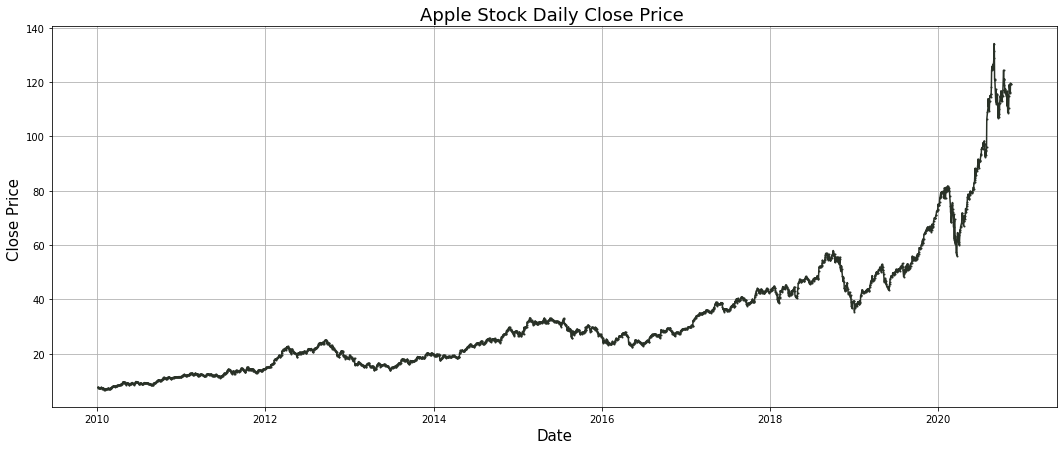

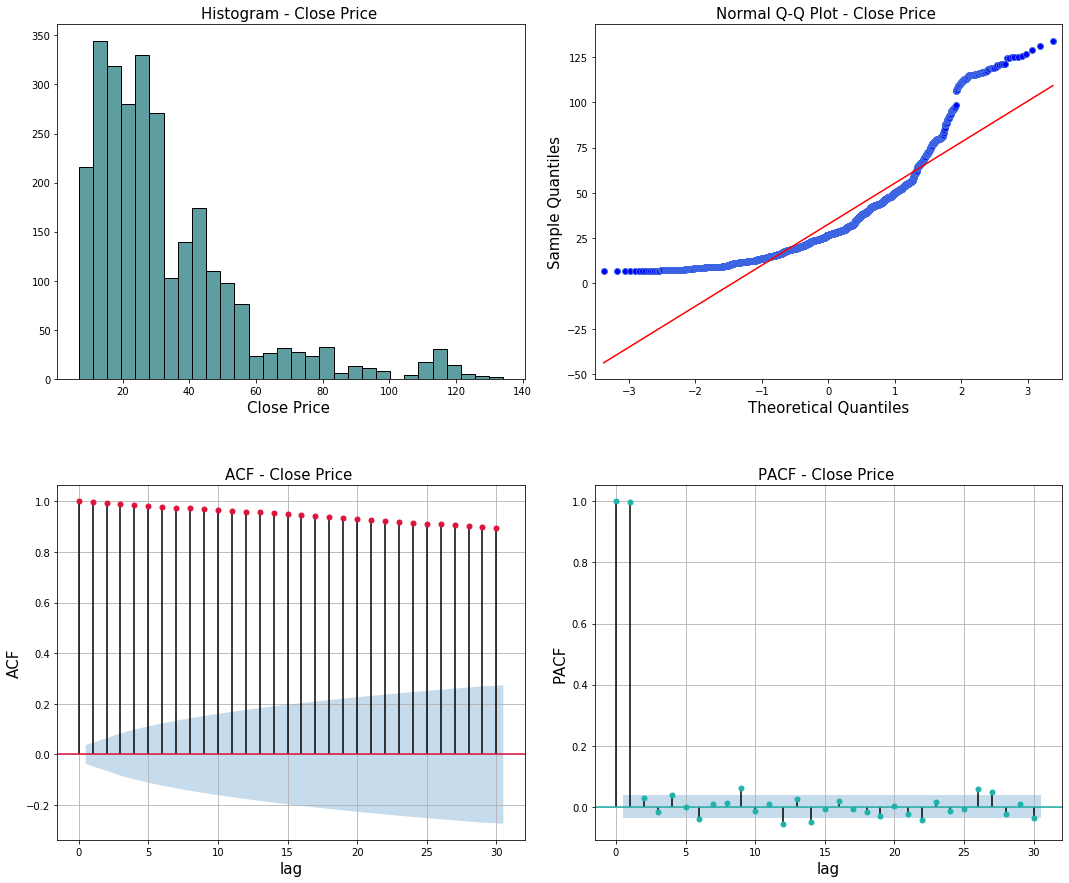

Augmented Dicky-Fuller Test - Apple Stock Daily Close Price 
Test Statistic: 2.9407
5% Critical Value: -2.8626
p-value: 1.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value >= alpha, Failed to reject the Null Hypothesis, the series is NOT Stationary.


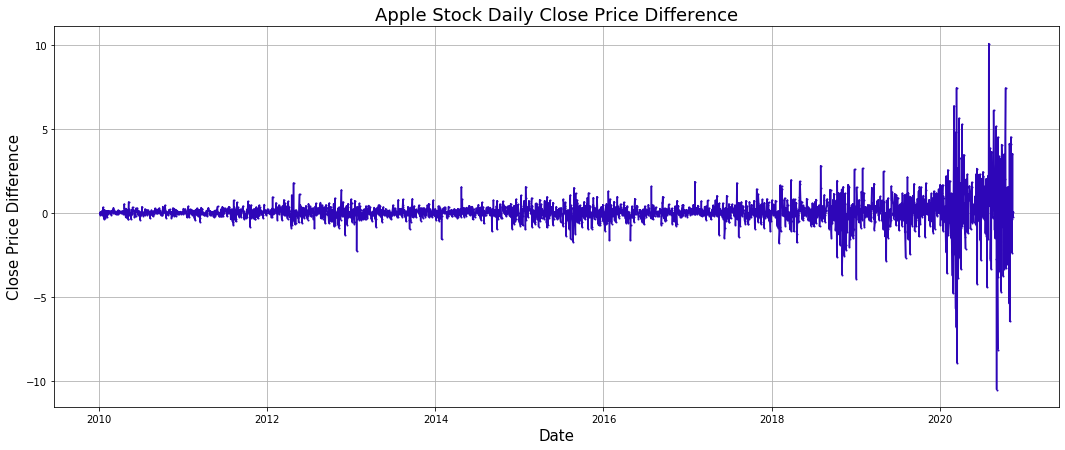

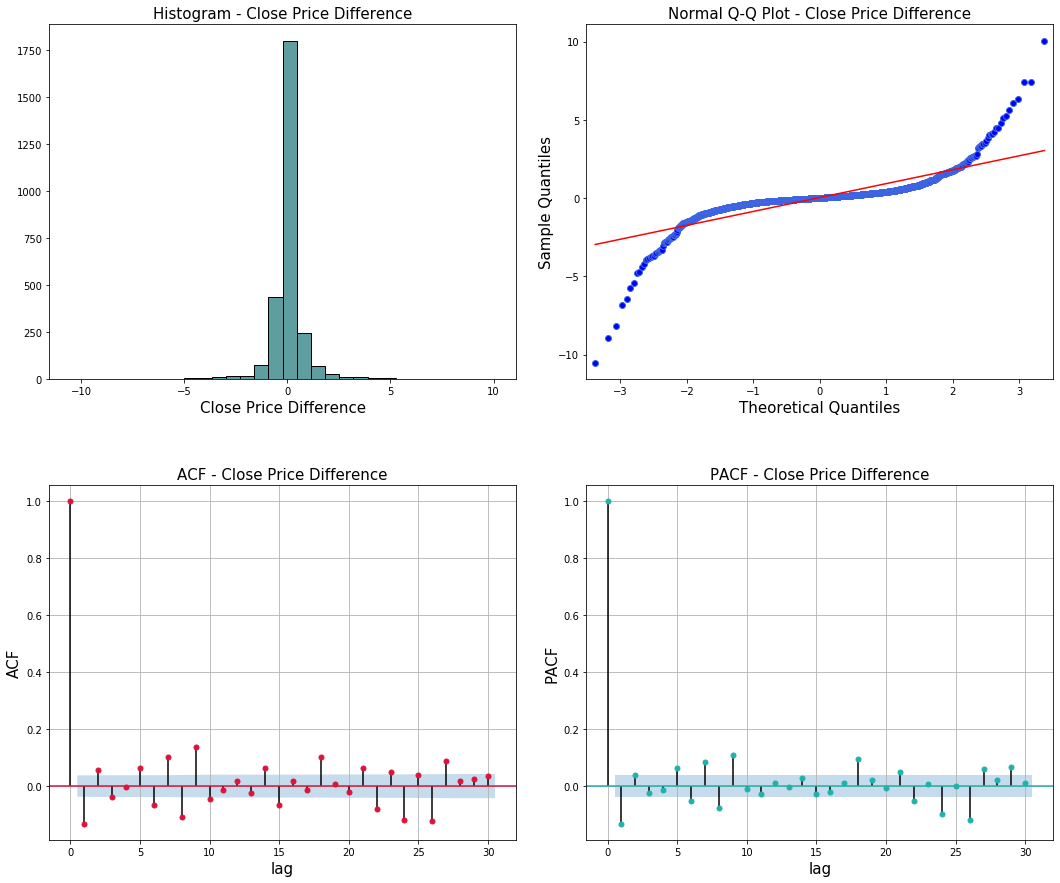

Augmented Dicky-Fuller Test - Apple Stock Daily Close Price Difference
Test Statistic: -9.0907
5% Critical Value: -2.8626
p-value: 0.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.


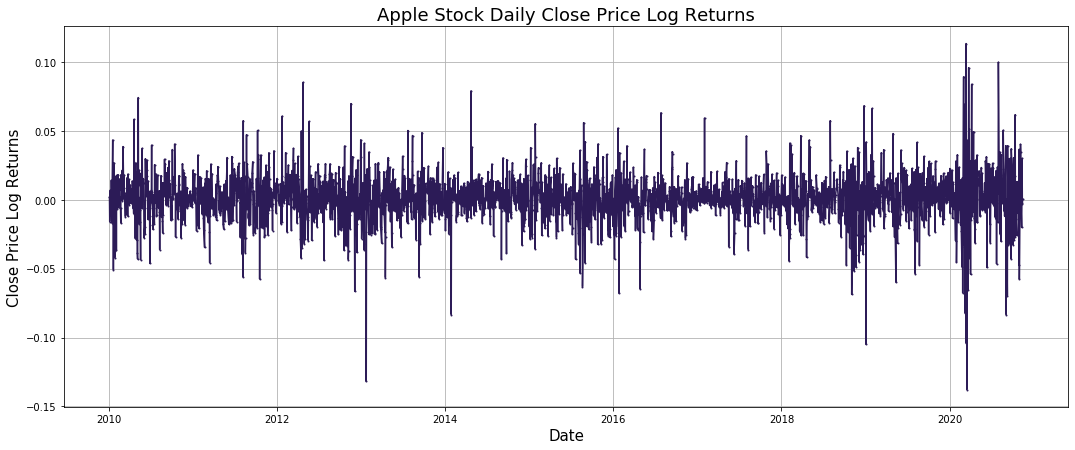

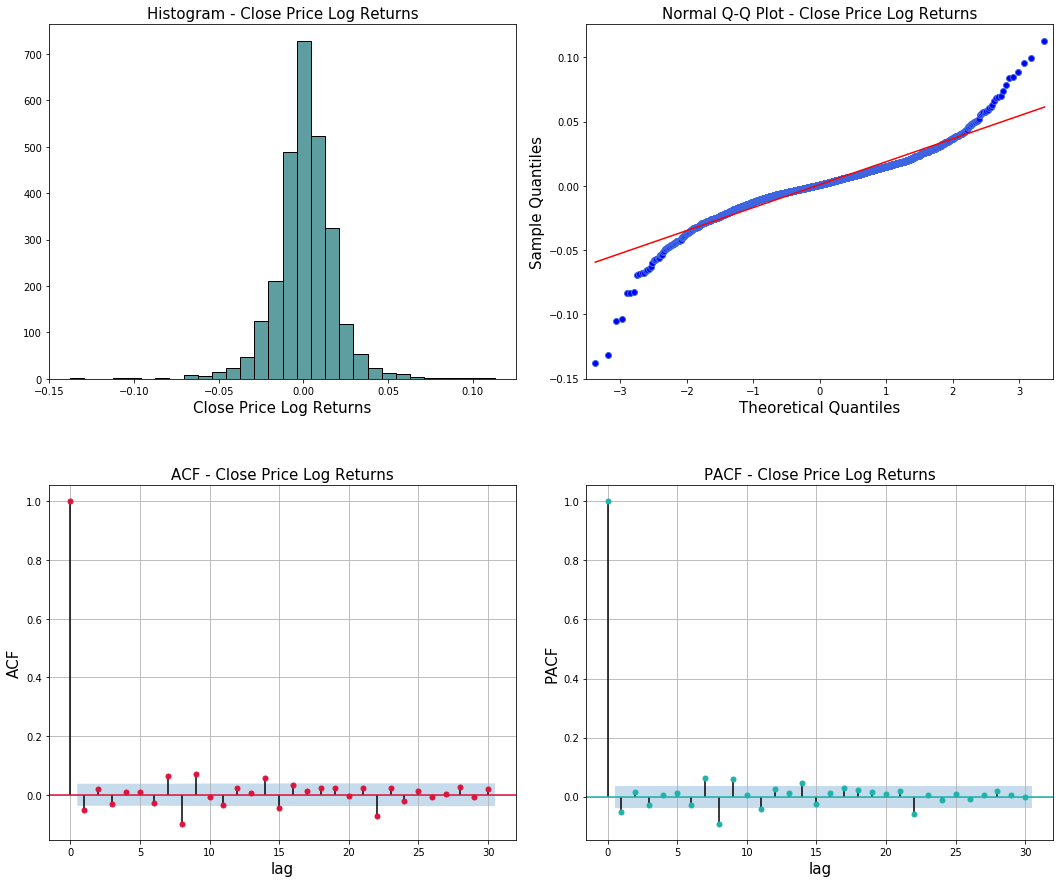

Augmented Dicky-Fuller Test - Apple Stock Daily Close Price Log Returns
Test Statistic: -10.6595
5% Critical Value: -2.8626
p-value: 0.0000
Signifiance Level (alpha): 0.05
Conclusion: p_value < alpha, Null Hypothesis Rejected, the series MIGHT be Stationary.

********************************************* Apple Stock Processing Finished *********************************************



In [36]:
# Display Synopsis, Plot Price, ACF & PACF Charts and do Augmented Dicky-Fuller Test for Price, Price Difference and Log Returns

for security in dfs_price:
    header = header_prefix + security + header_suffix
    print(header)

    df_price = dfs_price[security]
    df_price_diff = dfs_price_diff[security]
    df_log_returns = dfs_log_return[security]

    # Display Synopsis
    describe_and_peek(df_price, security)

    # Price
    display_insight_charts(df_price, security, "")
    augmented_dicky_fuller_test(df_price, security, "")

    # First Order Difference of Price
    display_insight_charts(df_price_diff, security, "Difference")
    augmented_dicky_fuller_test(df_price_diff, security, "Difference")

    # Daily Logarithmic Return
    display_insight_charts(df_log_returns, security, "Log Returns")
    augmented_dicky_fuller_test(df_log_returns, security, "Log Returns")
    
    footer = footer_prefix + security + footer_suffix
    print(footer)

# Price Prediction using Classical Time Series Models

In [37]:
# Displays Diagnostic Plots of the Residuals or Residuals Square
def residual_diagnostic(data, security_name, series_type):
    title = security_name + " Daily " + price_type + " Price - " + series_type + " - Diagnostic Plots"

    plt.figure(figsize=(18, 7))
    plt.plot(data, "-o", ms='1', color=np.random.rand(3,))
    plt.title(title, fontsize=18)
    plt.ylabel(series_type, fontsize=15)
    plt.grid(True)
    plt.show()
    
    fig, ax = plt.subplots(nrows=2, ncols=2, sharex=False, figsize=(18, 15))
    plt.subplots_adjust(wspace = 0.15, hspace = 0.3)
    h_max = 30
    
    ax[0, 0].hist(data, bins = 60, color='cadetblue', ec='black')
    ax[0, 0].set_title("Histogram - " + series_type, fontsize=15)
    ax[0, 0].set_xlabel(series_type, fontsize=15)
    
    qqplot(data, ax=ax[0, 1], line='s', color='royalblue')
    ax[0, 1].set_title('Normal Q-Q Plot - ' + series_type, fontsize=15)
    ax[0, 1].set_xlabel("Theoretical Quantiles", fontsize=15)
    ax[0, 1].set_ylabel("Sample Quantiles", fontsize=15)
 
    plot_acf(data, ax=ax[1, 0], lags=h_max, color='crimson')
    ax[1, 0].set_title("ACF - " + series_type, fontsize=15)
    ax[1, 0].set_xlabel("lag", fontsize=15)
    ax[1, 0].set_ylabel("ACF", fontsize=15)
    ax[1, 0].grid(True)

    plot_pacf(data, ax=ax[1, 1], lags=h_max, color='lightseagreen')
    ax[1, 1].set_title("PACF - " + series_type, fontsize=15)
    ax[1, 1].set_xlabel("lag", fontsize=15)
    ax[1, 1].set_ylabel("PACF", fontsize=15)
    ax[1, 1].grid(True)
    plt.show();

# Plots Actual, Fitted, Predicted Values and Confidence Intervals of the Predictions
def plot_original_fitted_pred(title, dates, actual, dates_train, fitted, dates_test, predictions, conf_int=None):
    plt.figure(figsize=(18, 7))
       
    # Plot Actual Values
    plt.plot(dates, actual, color='crimson', label = "Actual")
    
    # Plot Fitted Values
    plt.plot(dates_train, fitted, color='blue', label="Fitted")
    
    # Plot Separator Line
    plt.axvline(x=len(dates_train), linestyle='--', alpha=.2, color='k')
    
    # Plot Predicted Values
    plt.plot(dates_test, predictions, color='orange', label="Predicted")
    
    # Fill Prediction Region
    plt.fill_between(range(len(dates_train), len(dates)), -10, 150, color='pink', alpha=.3)
    
    # Plot Prediction Confidence Interval
    if conf_int is not None:
        pred_date_range = range(len(dates_train), len(dates))
        plt.fill_between(pred_date_range, conf_int[:,0], conf_int[:,1], color='cyan', alpha=.3, label="95% Prediction Conf Int")
 
    plt.title(title, fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel("Close Price", fontsize=15)
    plt.xticks(dates[::250])
    plt.legend(fontsize=12) 
    plt.show();

### Auto ARIMA Model (Optimal AR, MA and Differencing Orders Found in Automated Manner)

In [38]:
# Find optimal orders for SARIMA model
class Auto_Arima():
    def __init__(self, df, start_p=1, start_q=1, max_p=10, max_q=10, seasonal=False, information_criterion='aic'):
        self.df = df
        self.start_p = start_p
        self.start_q = start_q
        self.max_p = max_p
        self.max_q = max_q
        self.seasonal = seasonal
        self.information_criterion = information_criterion

    def arima_results(self):
        return pm.auto_arima(self.df, start_p=self.start_p, start_q=self.start_q, max_p=self.max_p, max_q=self.max_q,
                             seasonal=self.seasonal, information_criterion=self.information_criterion, trace = False,
                             error_action = 'ignore', suppress_warnings=True, stepwise = True, scoring = 'mse')

In [39]:
def auto_arima_model(df_price, security, price_type):
    model_name = "Auto ARIMA Model"
    
    print("-------------------------------------------------", model_name, "-----------------------------------------------\n")
    
    # Print Training and Test Set Sizes
    print("Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)

    # Split Into Train and Test Sets
    train = df_price[price_type][:-test_size]
    test = df_price[price_type][-test_size:]

    # Extract dates
    dates = df_price.index.format()
    dates_train = df_price.head(training_size).index.format()
    dates_test = df_price.tail(test_size).index.format()

    print("Training the model ...")

    # Fit model with auto-arima
    arima_model = Auto_Arima(train)
    model_fit = arima_model.arima_results()

    print("Training completed!\n")

    # Print the model summary
    print(model_fit.summary())    

    # Plot residuals diagnostics plots
    residuals = model_fit.resid()
    residual_diagnostic(residuals, security, "Auto ARIMA Fit Residuals")
    residual_diagnostic(residuals**2, security, "Auto ARIMA Fit Residuals Square")
    
    # Use the model to find fitted values
    fitted = model_fit.predict_in_sample()

    # Use the model to predict for the test data
    predictions, conf_int = model_fit.predict(n_periods=len(test), return_conf_int=True)

    # Plot Original, Fitted and Predicted Values
    title = security + " " + price_type + " Price - Actual, Fitted and Predicted Values - " + model_name
    plot_original_fitted_pred(title, dates, df_price[price_type], dates_train, fitted, dates_test, predictions, conf_int)

    return "Auto ARIMA", dates_test, test.values, np.array(predictions), mean_squared_error(test, predictions)

### Manual ARIMA Model  (Optimal AR, MA and Differencing Orders Found Manually)

In [40]:
def manual_arima_model(df_price, security, price_type):
    model_name = "Manual ARIMA Model"
    
    print("-----------------------------------------------", model_name, "-------------------------------------------------\n")
    
    # Print Training and Test Set Sizes
    print("Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)
    
    # Split Into Train and Test Sets
    train = df_price[price_type][:-test_size]
    test = df_price[price_type][-test_size:]
    
    # Extract dates
    dates = df_price.index.format()
    dates_train = df_price.head(training_size).index.format()
    dates_test = df_price.tail(test_size).index.format()

    print("Training the model ...")
    print("Trying order combinations to find the best combination...")

    # Find best p, d and q values
    min_aic = np.inf
    best_orders = None
    best_model = None
    
    for p in range(6):
        for d in range(2):
            for q in range(6):
                model = ARIMA(train.values, order=(p, d, q), trend='n')
                model_fit = model.fit()                
                aic = model_fit.aic
                if aic < min_aic:
                    min_aic = aic
                    best_orders = (p, d, q)
                    best_model = model_fit
                    
    print("Best AR Order (p):", best_orders[0])
    print("Best Differencing Order (d):", best_orders[1])
    print("Best MA Order (q):", best_orders[2])    
    print("Training completed!\n")

    # Print the best model summary 
    print(best_model.summary())
    
    # Plot residuals diagnostics plots
    residuals = model_fit.resid
    residual_diagnostic(residuals, security, "Manual ARIMA Fit Residuals")
    residual_diagnostic(residuals**2, security, "Manual ARIMA Fit Residuals Square")
    
    # Use the model to find fitted values
    fitted = best_model.predict()
    
    # Use the model to predict for the test data
    forecast_results = best_model.get_forecast(steps=test_size)
    predictions = forecast_results.predicted_mean
    conf_int = forecast_results.conf_int()
    
    # Plot Original, Fitted and Predicted Values
    title = security + " " + price_type + " Price - Actual, Fitted and Predicted Values - " + model_name
    plot_original_fitted_pred(title, dates, df_price[price_type], dates_train, fitted, dates_test, predictions, conf_int)

    return "Manual ARIMA", dates_test, test.values, np.array(predictions), mean_squared_error(test, predictions)

### AR-ARCH Model

In [41]:
def ar_arch_model(df_price, df_price_diff, security, price_type):
    model_name = "AR ARCH Model"
    
    print("-----------------------------------------------", model_name, "-------------------------------------------------\n")

    # Print Training and Test Set Sizes
    print("Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)

    # Split Into Train and Test Sets
    train = df_price[price_type][:-test_size]
    test = df_price[price_type][-test_size:]
    
    # Extract dates
    dates = df_price.index.format()
    dates_train = df_price.head(training_size).index.format()
    dates_test = df_price.tail(test_size).index.format()

    print("Training the model ...")
    print("Trying order combinations to find the best combination...")
    
    # Find best lags, p and q values
    min_aic = np.inf
    best_orders = None
    best_model = None
    
    for lags in range(10):
        for p in range(1, 10):
            for q in range(10):
                model_fit = arch_model(train, mean='AR', lags=lags, vol='ARCH', p=p, q=q).fit(disp='off')
                aic = model_fit.aic
                if aic < min_aic:
                    min_aic = aic
                    best_orders = (lags, p, q)
                    best_model = model_fit

    print("Best Lags Value:", best_orders[0])
    print("Best p Value:", best_orders[1])
    print("Best q Value:", best_orders[2])
    print("Training completed!\n")

    # Print the best model summary
    print(best_model.summary())

    # Plot residuals diagnostics plots
    residuals = model_fit.resid.dropna()
    residual_diagnostic(residuals, security, "AR ARCH Fit Residuals")
    residual_diagnostic(residuals**2, security, "AR ARCH Fit Residuals Square")
    
    # arch_model doesn't provide fitted values, so using actual values
    fitted = train
    
    # Use the model to predict for the test data
    forecast_results = best_model.forecast(horizon=test_size)
    predictions = forecast_results.mean.values[-1, :]
    conf_int_left = predictions - 1.96*np.sqrt(forecast_results.variance.values[-1, :])
    conf_int_right = predictions + 1.96*np.sqrt(forecast_results.variance.values[-1, :])
    conf_int = np.array([conf_int_left, conf_int_right]).transpose()    

    # Plot Original, Fitted and Predicted Values
    title = security + " " + price_type + " Price - Actual, Fitted and Predicted Values - " + model_name
    plot_original_fitted_pred(title, dates, df_price[price_type], dates_train, fitted, dates_test, predictions, conf_int)

    return "AR ARCH", dates_test, test.values, predictions, mean_squared_error(test, predictions)

### Run all the Classical Time Series Models and Display Results of Individual Models

In [42]:
# Dictionary to store the mse results of all the models
mse_values = {}

# Perecentage training size
training_percentage = 0.9


*************************************************** Processing Apple Stock ************************************************

Classical Time Series Models: Total Size: 2737 Training Size: 2463 Test Size: 274


------------------------------------------------- Auto ARIMA Model -----------------------------------------------

Total Size: 2737 Training Size: 2463 Test Size: 274
Training the model ...
Training completed!

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2463
Model:               SARIMAX(0, 1, 0)   Log Likelihood               -1669.231
Date:                Sat, 12 Dec 2020   AIC                           3342.461
Time:                        05:42:55   BIC                           3354.079
Sample:                             0   HQIC                          3346.682
                               - 2463                                         
Covariance Type:         

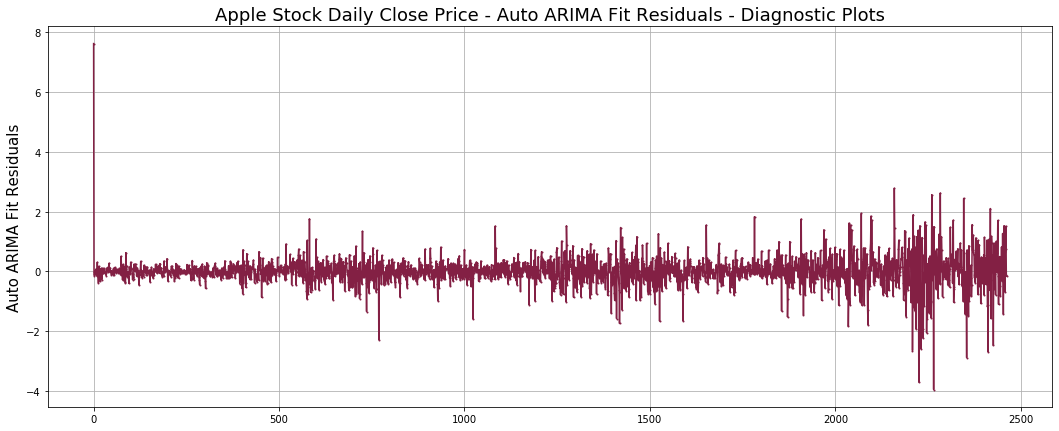

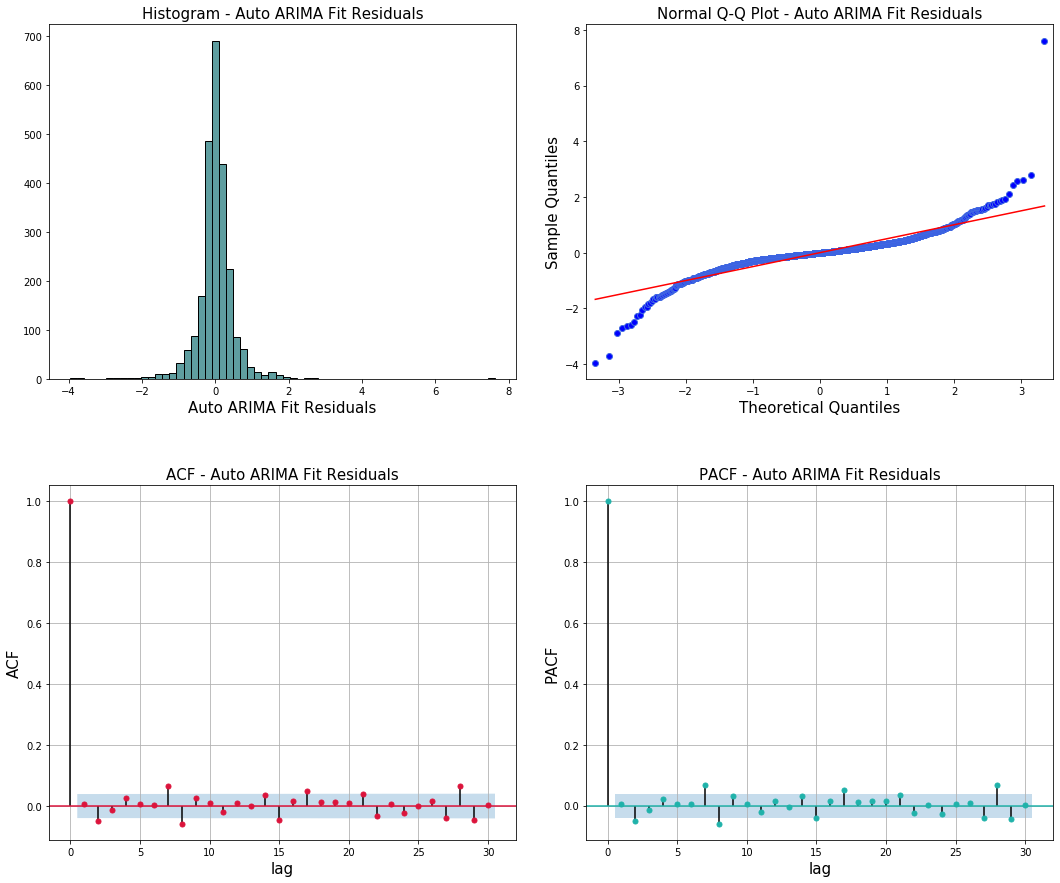

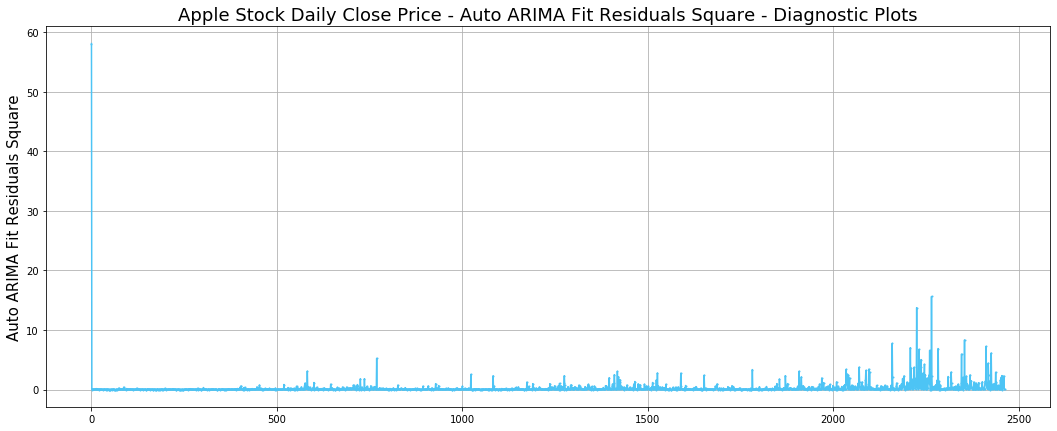

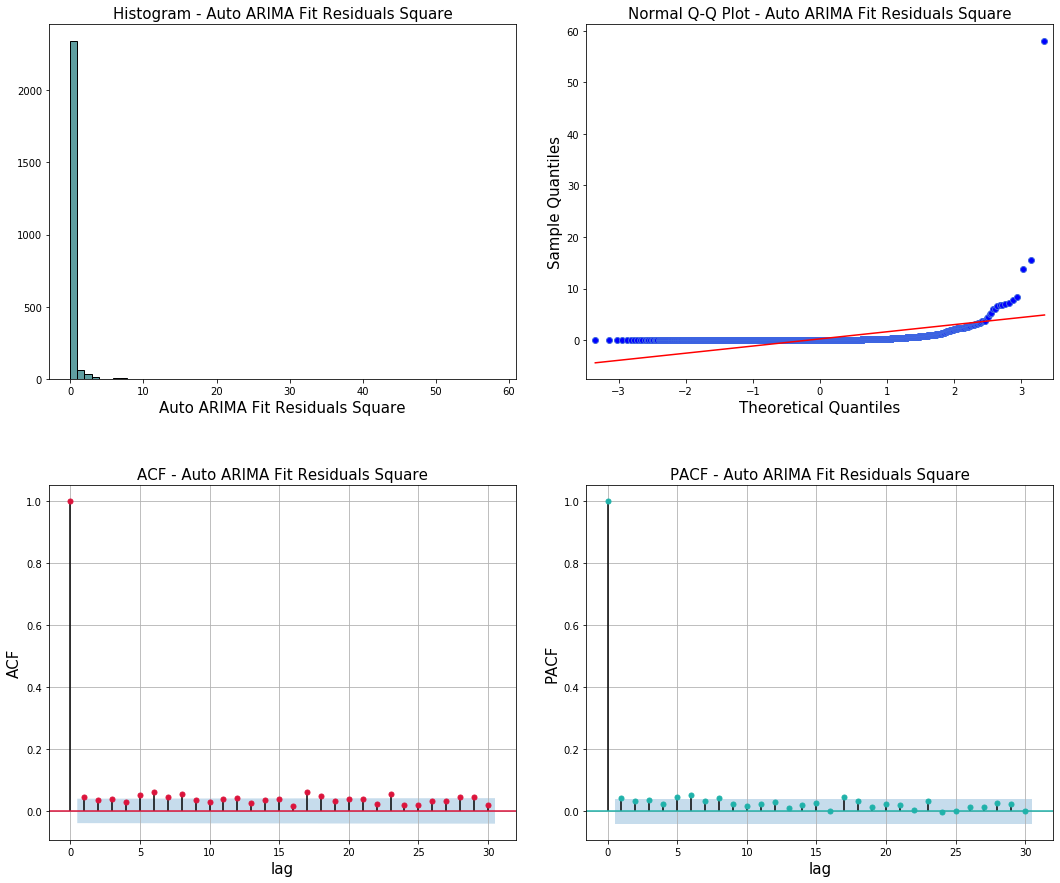

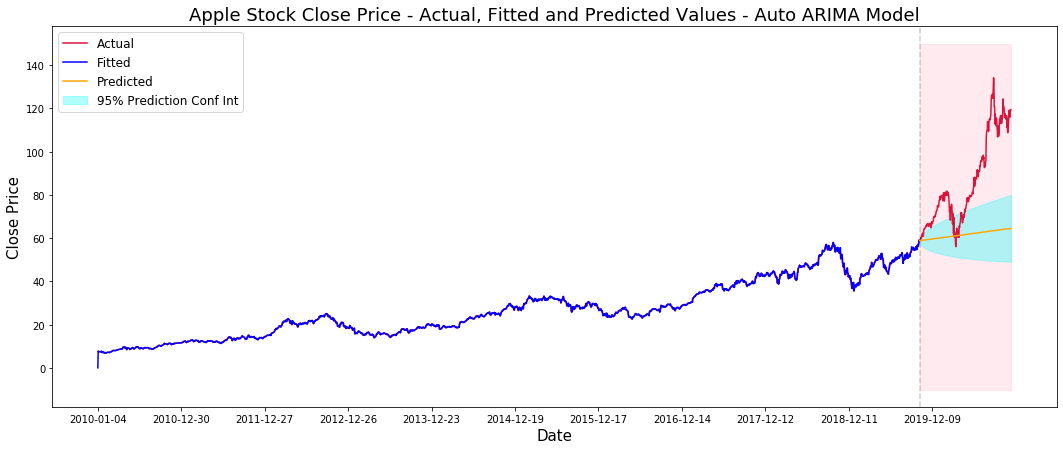

----------------------------------------------- Manual ARIMA Model -------------------------------------------------

Total Size: 2737 Training Size: 2463 Test Size: 274
Training the model ...
Trying order combinations to find the best combination...


C:\Users\bauna\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\bauna\AppData\Roaming\Python\Python37\site-packages\statsmodels\tsa\statespace\sarimax.py:966: UserWarning: Non-stationary starting autoregressive parameters found. Using zeros as starting parameters.
  warn('Non-stationary starting autoregressive parameters'


Best AR Order (p): 2
Best Differencing Order (d): 1
Best MA Order (q): 4
Training completed!

                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2463
Model:                 ARIMA(2, 1, 4)   Log Likelihood               -1651.776
Date:                Sat, 12 Dec 2020   AIC                           3317.552
Time:                        05:44:47   BIC                           3358.213
Sample:                             0   HQIC                          3332.326
                               - 2463                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -1.7332      0.020    -88.014      0.000      -1.772      -1.695
ar.L2         -0.9406      0.018    -

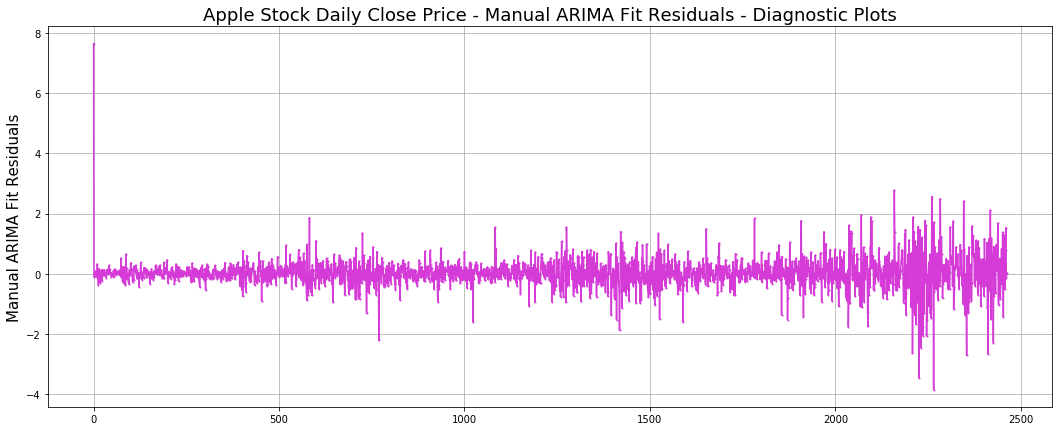

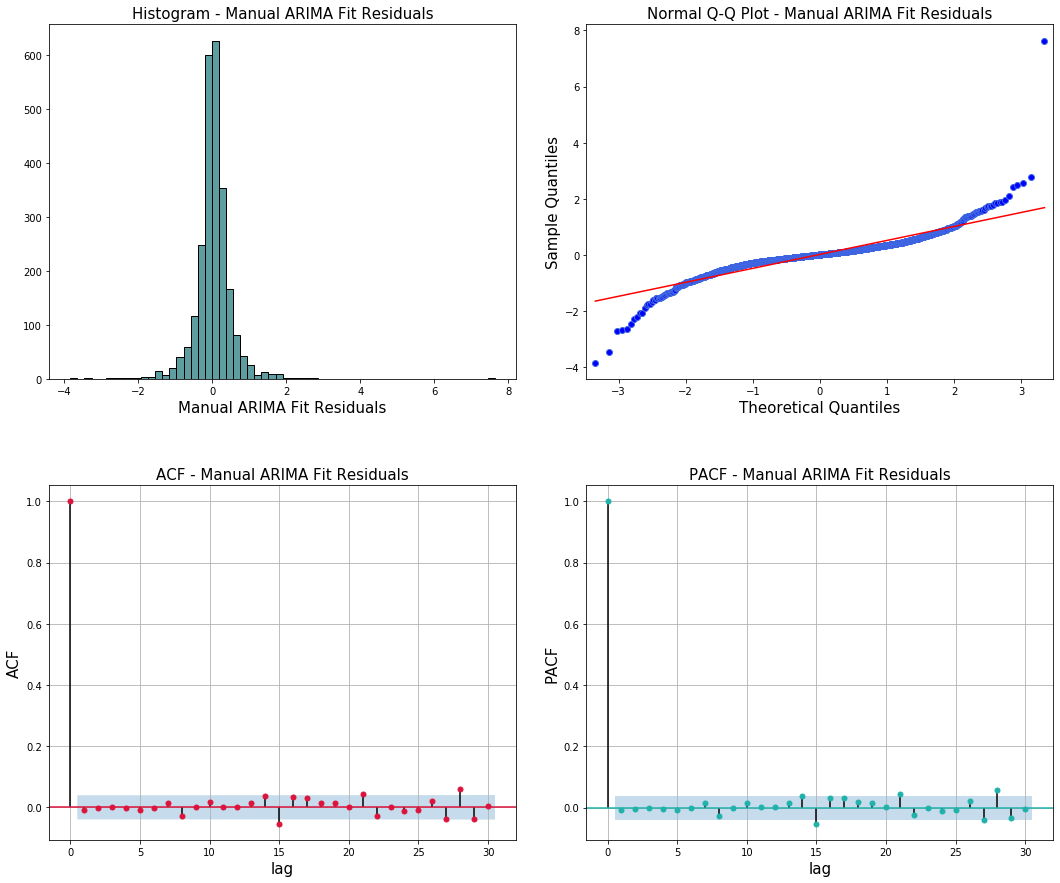

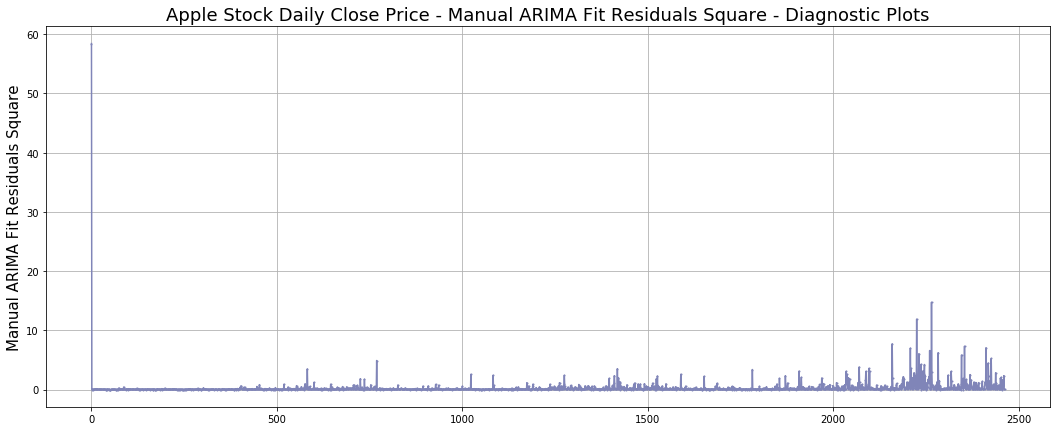

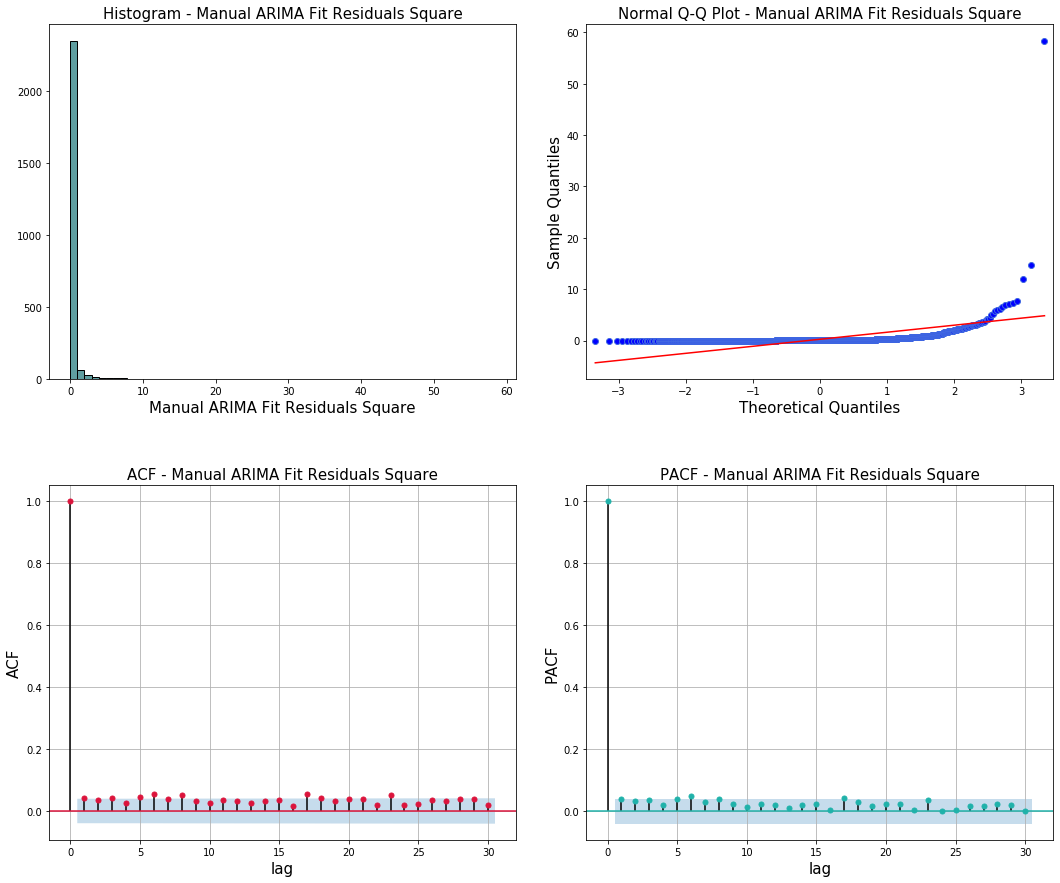

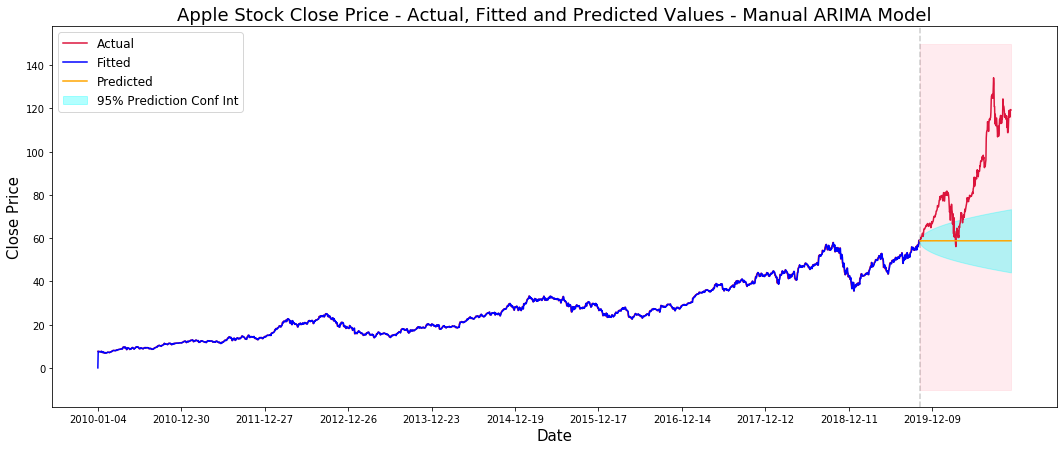

----------------------------------------------- AR ARCH Model -------------------------------------------------

Total Size: 2737 Training Size: 2463 Test Size: 274
Training the model ...
Trying order combinations to find the best combination...
Best Lags Value: 1
Best p Value: 9
Best q Value: 0
Training completed!

                           AR - ARCH Model Results                            
Dep. Variable:                  Close   R-squared:                       0.999
Mean Model:                        AR   Adj. R-squared:                  0.999
Vol Model:                       ARCH   Log-Likelihood:               -1124.96
Distribution:                  Normal   AIC:                           2273.91
Method:            Maximum Likelihood   BIC:                           2343.62
                                        No. Observations:                 2462
Date:                Sat, Dec 12 2020   Df Residuals:                     2450
Time:                        05:45:05   Df Model: 

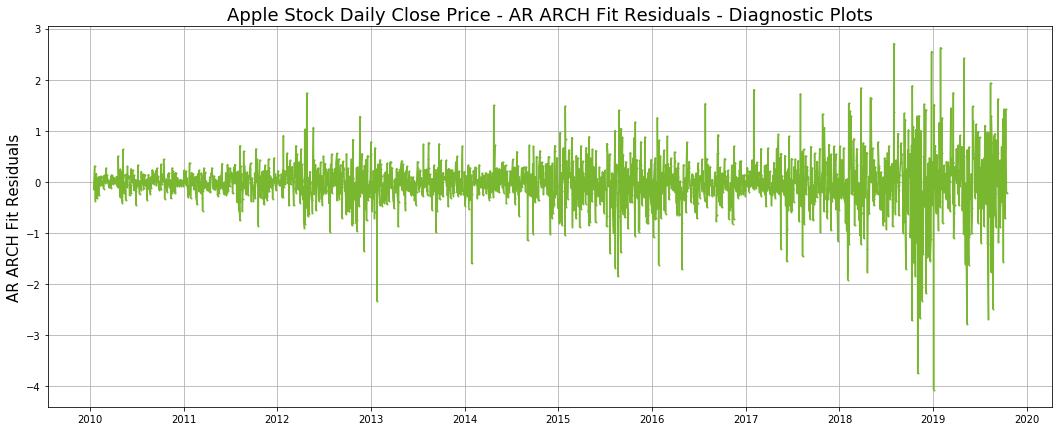

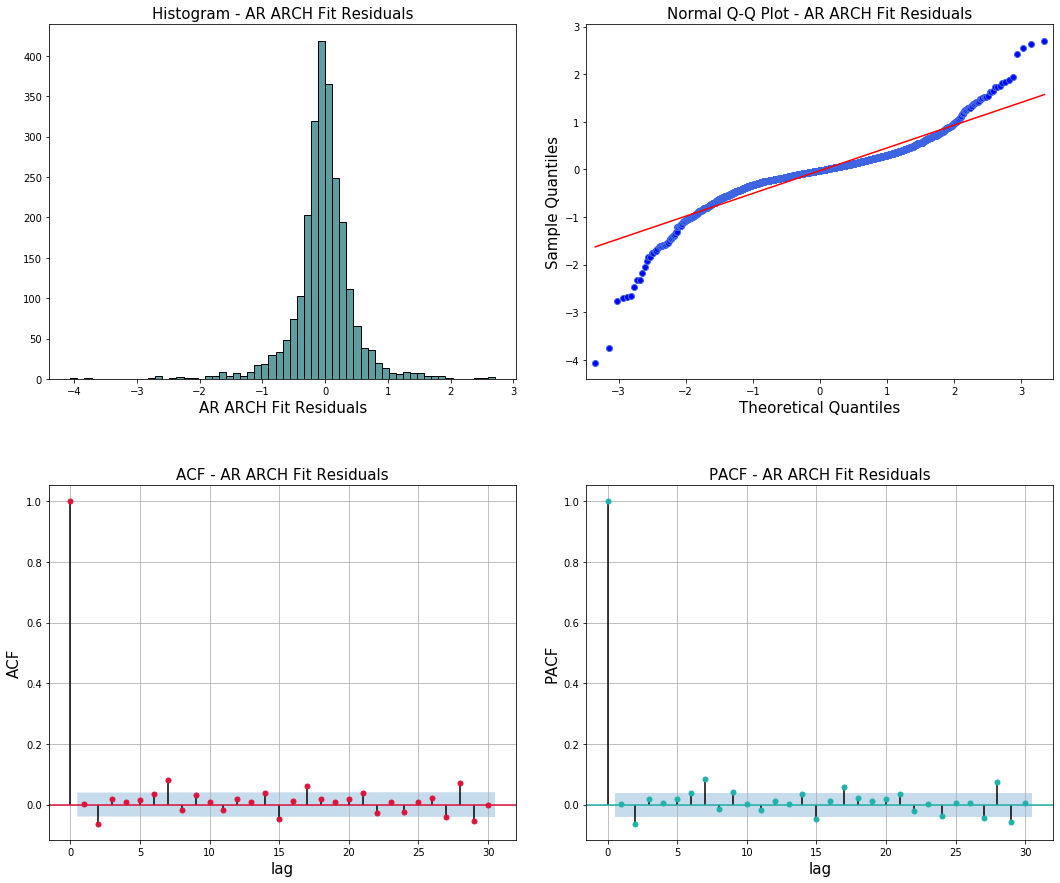

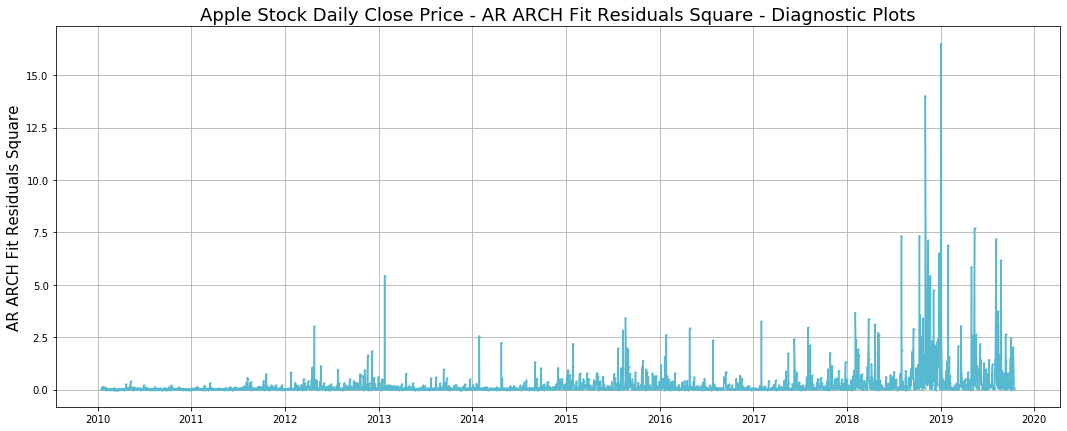

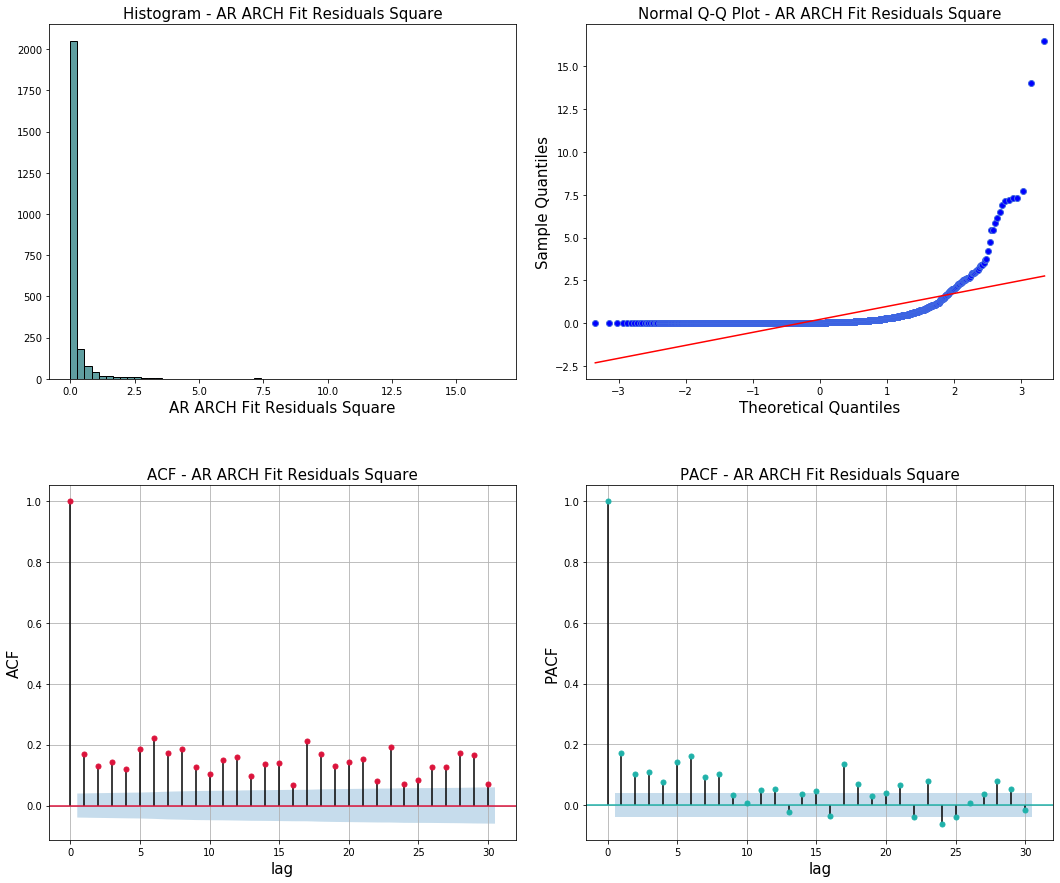

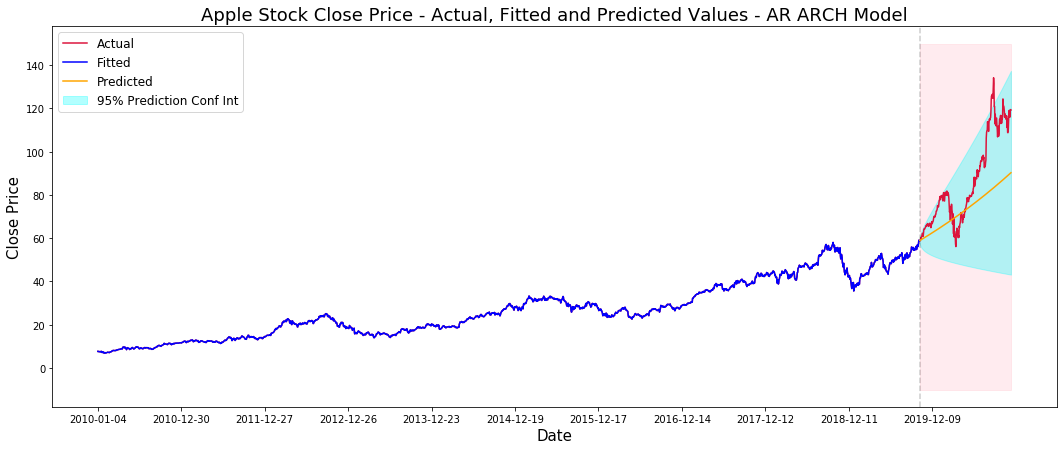


********************************************* Apple Stock Processing Finished *********************************************



In [43]:
# Dictionary to store the results of all the classical models
classical_results = {}

# Build and predict using all the classical time series models
for security in dfs_price_scaled:
    header = header_prefix + security + header_suffix
    print(header)

    security_results = {}
    security_mse = {}

    price = dfs_price[security]
    price_diff = dfs_price_diff[security]    
    scaler = scalers[security]

    total_size = len(price)
    
    # Compute Training and Test Set Sizes
    training_size = int(total_size * training_percentage)
    test_size = total_size - training_size

    # Print Training and Test Set Sizes
    print("Classical Time Series Models: Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)
    print('\n')
    
    model, dates, actual, predictions, mse = auto_arima_model(price, security, price_type)
    security_results[model] = dates, actual, predictions
    security_mse[model] = mse
    
    model, dates, actual, predictions, mse = manual_arima_model(price, security, price_type)
    security_results[model] = dates, actual, predictions
    security_mse[model] = mse
    
    model, dates, actual, predictions, mse = ar_arch_model(price, price_diff, security, price_type)
    security_results[model] = dates, actual, predictions
    security_mse[model] = mse
    
    classical_results[security] = security_results
    mse_values[security] = security_mse
    
    footer = footer_prefix + security + footer_suffix
    print(footer)

### Display Price Prediction of all the Classical Time Series Models

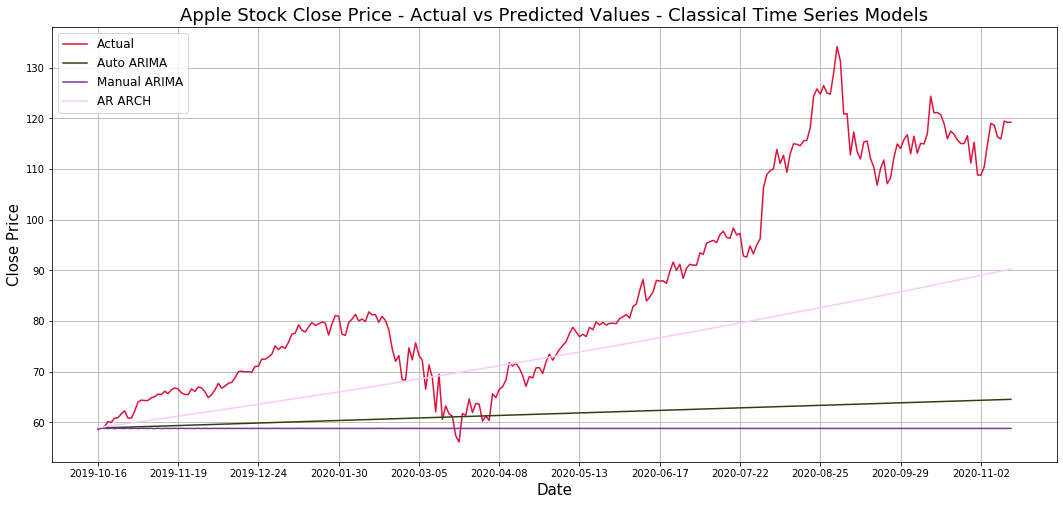

In [44]:
for security, security_results in classical_results.items():
    actual_displayed = False
    model_list = []
    
    plt.figure(figsize=(18, 8))
    for model, model_results in security_results.items():
        dates, actual, predictions = model_results
        model_list.append(model)
        if not actual_displayed:
            plt.plot(dates, actual, "-", color='crimson', label='Actual')
            actual_displayed = True

        plt.plot(dates, predictions, "-", color=np.random.rand(3,), label=model)

    plt.title(security + " " + price_type + " Price - Actual vs Predicted Values - Classical Time Series Models", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price", fontsize=15)
    plt.xticks(dates[::24])
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show();

# Price Prediction using LSTM Models

## Common Functions for all the Models

In [45]:
# Given history displays Loss and RMSE curves
def plot_loss_and_rmse(history, title_prefix):
    # Extract loss and accuracy
    loss = history.history['loss']
    rmse = history.history['rmse']

    val_loss = history.history['val_loss']
    val_rmse = history.history['val_rmse']

    epochs = range(1, len(loss) + 1)
    
    fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(21, 8))
    plt.suptitle(title_prefix + "Loss and RMSE", fontsize=18)

    ax[0].plot(epochs, loss, '-o', label='Training Loss')
    ax[0].plot(epochs, val_loss, '-o', color='r', label='Validation Loss')
    ax[0].grid(color='black', which='major', linestyle='dashed')
    ax[0].set_title('Training and Validation Loss', fontsize=18)
    ax[0].set_xlabel('Epochs', fontsize=15)
    ax[0].set_ylabel('Loss', fontsize=15)
    ax[0].legend(fontsize=12)

    ax[1].plot(epochs, rmse, '-o', label='Training RMSE')
    ax[1].plot(epochs, val_rmse, '-o', color='r', label='Validation RMSE')
    ax[1].grid(color='black', which='major', linestyle='dashed')
    ax[1].set_title('Training and Validation RMSE', fontsize=18)
    ax[1].set_xlabel('Epochs', fontsize=15)
    ax[1].set_ylabel('RMSE', fontsize=15)
    ax[1].legend(fontsize=12)

    plt.show();
    
# Displays Actual and Predicted prices for given dates
def plot_actual_vs_predicted(dates, actual, predictions, title_prefix, price_type):
    plt.figure(figsize=(21, 8))
    plt.plot(dates, actual, "-o", color='b', label='Actual')
    plt.plot(dates, predictions, "-o", color='r', label='Predicted')
    plt.title(title_prefix + "Actual vs Predicted", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price (USD)", fontsize=15)
    plt.xticks(dates[::6])
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show();

In [46]:
def build_complie_train_model(train_features, train_labels, val_features, val_labels, look_ahead):
    
    # Extract Input Shape
    input_shape = (train_features.shape[1], train_features.shape[2])
    
    # Create the model
    model = Sequential()

    # Add LSTM and Dropout Layers
    model.add(CuDNNLSTM(units=150, return_sequences=True, input_shape=input_shape))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150, return_sequences=True))
    model.add(Dropout(0.2))

    model.add(CuDNNLSTM(units=150))
    model.add(Dropout(0.2))

    # Add dense layers
    model.add(Dense(units = look_ahead))

    # Compile the Model
    model.compile(optimizer = 'adam', loss = 'mean_squared_error', metrics=[RootMeanSquaredError(name='rmse')])

    print("Training the model ...")

    # Train the model
    history = model.fit(train_features,
                        train_labels,
                        epochs=1,
                        batch_size=32,
                        validation_data=(val_features, val_labels),
                        verbose=verbose)

    print("Training completed!\n")
    
    return model, history

### Model 1 - Univariate Model

In [47]:
def univariate_model(df_price, scalers, security, price_type):
    model_name = "Univariate LSTM Model"
    
    print("-----------------------------------------------", model_name, "-------------------------------------------------\n")

    # Print Training and Test Set Sizes
    print("Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 1
    title_prefix = security + " " + price_type + " Price - Univariate LSTM Model - "

    # Extract price and scaler for the price type
    price = df_price[[price_type]].values
    scaler = scalers[price_type]
    
    # Extract dates
    dates = df_price[window_size:].index.format()
    dates_train = df_price[window_size:].head(training_size).index.format()
    dates_test = df_price[window_size:].tail(test_size).index.format()

    # Create Training and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price)):
        if i < window_size + training_size:
            train_features.append(price[i-window_size:i, 0])
            train_labels.append(price[i, 0])
        else:
            test_features.append(price[i-window_size:i, 0])
            test_labels.append(price[i, 0])
    
    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Reshape Training and Test Feature Sets to fit LSTM input shape
    train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    
    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, test_features, test_labels, look_ahead)

    # Save the model
    model.save("lstm_univariate_" + security + '.h5', save_format='tf')
    
    # Print the model summary
    print(model.summary())
    
    # Display loss and RMSE curves
    plot_loss_and_rmse(history, title_prefix)
    
    # Use the model to find fitted values and convert to origianl scale
    fitted = scaler.inverse_transform(model.predict(train_features)) 

    # Use the model to predict for the test data and convert to origianl scale
    predictions = scaler.inverse_transform(model.predict(test_features))
    
    # Convert all actual values to the origianl scale
    actual = scaler.inverse_transform(price)

    # Plot Actual, Fitted and Predicted Values
    title = security + " " + price_type + " Price - Actual, Fitted and Predicted Values - " + model_name
    plot_original_fitted_pred(title, dates, actual[window_size:], dates_train, fitted, dates_test, predictions)   

    # Convert actual test values to the origianl scale
    actual = scaler.inverse_transform(test_labels.reshape(-1, 1))
    
    return "Univariate LSTM", dates_test, actual, predictions, mean_squared_error(actual, predictions)

### Model 2 - Univariate Multiday Look ahead Model

In [48]:
def univariate_multiday_look_ahead_model(df, scalers, security, price_type):
    model_name = "Univariate MultiDay Look ahead LSTM Model"
    
    print("-----------------------------------------", model_name, "-------------------------------------------\n")

    # Print Training and Test Set Sizes
    print("Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 3
    title_prefix = security + " " + price_type + " Price - Univariate Multiday Look ahead LSTM Model - "

    # Extract price and scaler for the price type
    price = df[[price_type]].values
    scaler = scalers[price_type]
    
    # Extract dates
    dates = df_price[window_size:].index.format()
    dates_train = df_price[window_size:].head(training_size).index.format()
    dates_test = df_price[window_size:].tail(test_size).index.format()

    # Create Training and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price) - look_ahead + 1):  
        if i < window_size + training_size:
            train_features.append(price[i-window_size:i, 0])
            train_labels.append(price[i:i+look_ahead, 0])
        else:
            test_features.append(price[i-window_size:i, 0])
            test_labels.append(price[i:i+look_ahead, 0])
    
    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Reshape data to fit LSTM input shape
    train_features = np.reshape(train_features, (train_features.shape[0], train_features.shape[1], 1))
    test_features = np.reshape(test_features, (test_features.shape[0], test_features.shape[1], 1))
    
    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, test_features, test_labels, look_ahead)

    # Save the model
    model.save("lstm_univariate_multiday_look_ahead_" + security + '.h5', save_format='tf')
    
    # Print the model summary
    print(model.summary())
    
    # Display loss and RMSE curves
    plot_loss_and_rmse(history, title_prefix) 
    
    # Use the model to find fitted values and convert to origianl scale
    fitted = scaler.inverse_transform(model.predict(train_features))

    # Use the model to predict for the test data and convert to origianl scale
    predictions = scaler.inverse_transform(model.predict(test_features))
    
    # Convert all actual values to the origianl scale
    actual = scaler.inverse_transform(price)   
    
    model_names = np.empty(look_ahead, dtype=object)
    model_dates = np.empty((test_size-look_ahead+1, look_ahead), dtype=object)
    model_mse = np.empty(look_ahead)
    actual_test = np.empty((test_labels.shape[0], look_ahead), dtype=object)

    for i in range(look_ahead):
        model_names[i] = "Univariate: Lahead-" + str(i+1)       
        model_dates[:, i] = np.array(dates_test[i:i+test_size-look_ahead+1])        
        actual_test[:, i] = scaler.inverse_transform(test_labels[:, i].reshape(-1, 1)).ravel()        
        model_mse[i] = mean_squared_error(actual_test[:, i], predictions[:, i])

        # Plot Actual, Fitted and Predicted Values
        title = security + " " + price_type + " Price - Actual, Fitted and Predicted Values - " + model_names[i]
        plot_original_fitted_pred(title, dates, actual[window_size:], dates_train, fitted[:, i], model_dates[:, i], predictions[:, i])
    
    return model_names, model_dates, actual_test, predictions, model_mse

### Model 3 - Multivariate Model

In [49]:
def multivariate_model(df, scalers, security, price_type):
    model_name = "Multivariate LSTM Model"
    
    print("-----------------------------------------------", model_name, "-------------------------------------------------\n")

    # Print Training and Test Set Sizes
    print("Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)

    # Number of days to predict
    look_ahead = 1
    title_prefix = security + " " + price_type + " Price - Multivariate LSTM Model - "

    # Extract price and scaler for the price type
    price_all = df.values
    price = df[[price_type]].values
    scaler = scalers[price_type]

    # Extract dates
    dates = df_price[window_size:].index.format()
    dates_train = df_price[window_size:].head(training_size).index.format()
    dates_test = df_price[window_size:].tail(test_size).index.format()

    # Create Training and Test Feature Sets and Labels
    train_features = []
    train_labels = []

    test_features = []
    test_labels = []

    for i in range(window_size, len(price)):
        if i < window_size + training_size:
            train_features.append(price_all[i-window_size:i, :])
            train_labels.append(price[i, 0])        
        else:
            test_features.append(price_all[i-window_size:i, :])
            test_labels.append(price[i, 0])

    # Convert features set and label lists to numpy arrays
    train_features, train_labels = np.array(train_features), np.array(train_labels)
    test_features, test_labels = np.array(test_features), np.array(test_labels)

    # Create and train a new sequential model as per the specifications
    model, history = build_complie_train_model(train_features, train_labels, test_features, test_labels, look_ahead)

    # Save the model
    model.save("lstm_multivariate_" + security + '.h5', save_format='tf')    

    # Print the model summary
    print(model.summary())
    
    # Display loss and RMSE curves
    plot_loss_and_rmse(history, title_prefix)
    
    # Use the model to find fitted values and convert to origianl scale
    fitted = scaler.inverse_transform(model.predict(train_features))

    # Use the model to predict for the test data and convert to origianl scale
    predictions = scaler.inverse_transform(model.predict(test_features))
    
    # Convert all actual values to the origianl scale
    actual = scaler.inverse_transform(price)

    # Plot Actual, Fitted and Predicted Values
    title = security + " " + price_type + " Price - Actual, Fitted and Predicted Values - " + model_name
    plot_original_fitted_pred(title, dates, actual[window_size:], dates_train, fitted, dates_test, predictions)   

    # Convert actual test values to the origianl scale
    actual = scaler.inverse_transform(test_labels.reshape(-1, 1))

    return "Multivariate LSTM", dates_test, actual, predictions, mean_squared_error(actual, predictions)

### Run all the LSTM Models and Display Results of Individual Models


*************************************************** Processing Apple Stock ************************************************

LSTM Models: Total Size: 2737 Training Size: 2403 Test Size: 274


----------------------------------------------- Univariate LSTM Model -------------------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_12 (CuDNNLSTM)    (None, 60, 150)           91800     
_________________________________________________________________
dropout_12 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_13 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________________________________________
dropout_13 (Dropout)         (None, 60, 

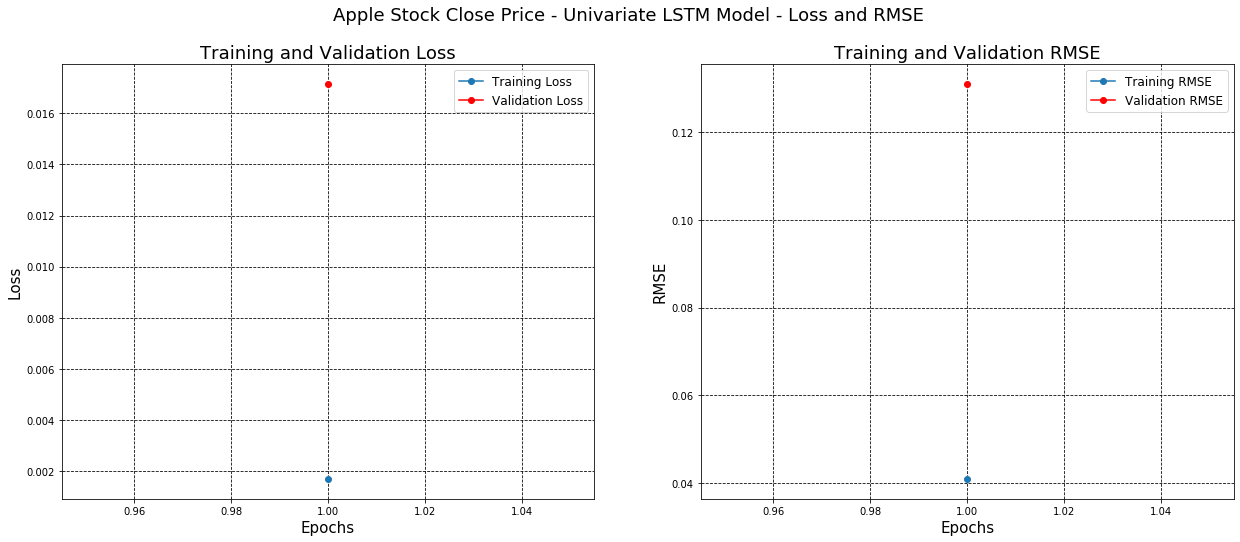

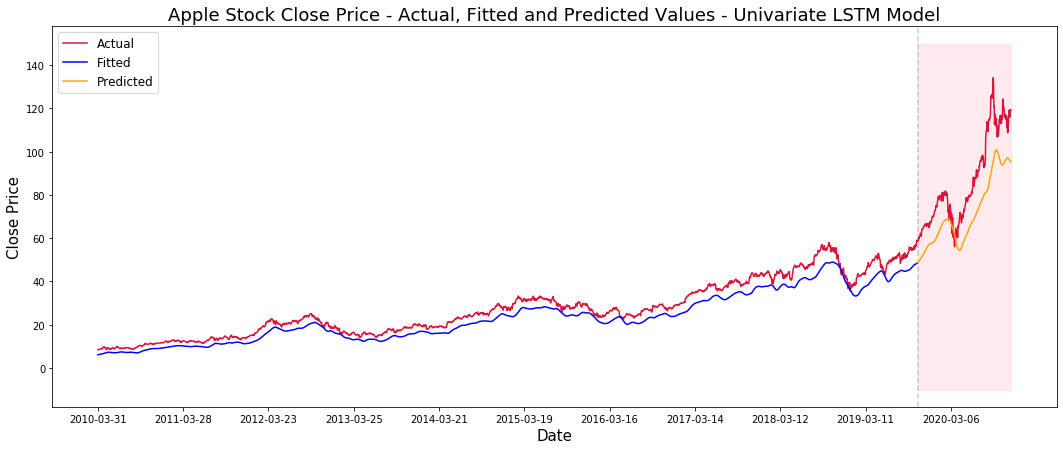

----------------------------------------- Univariate MultiDay Look ahead LSTM Model -------------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_16 (CuDNNLSTM)    (None, 60, 150)           91800     
_________________________________________________________________
dropout_16 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_17 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________________________________________
dropout_17 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_18 (CuDNNLSTM)    (None, 60, 150)           181200    
___________________________

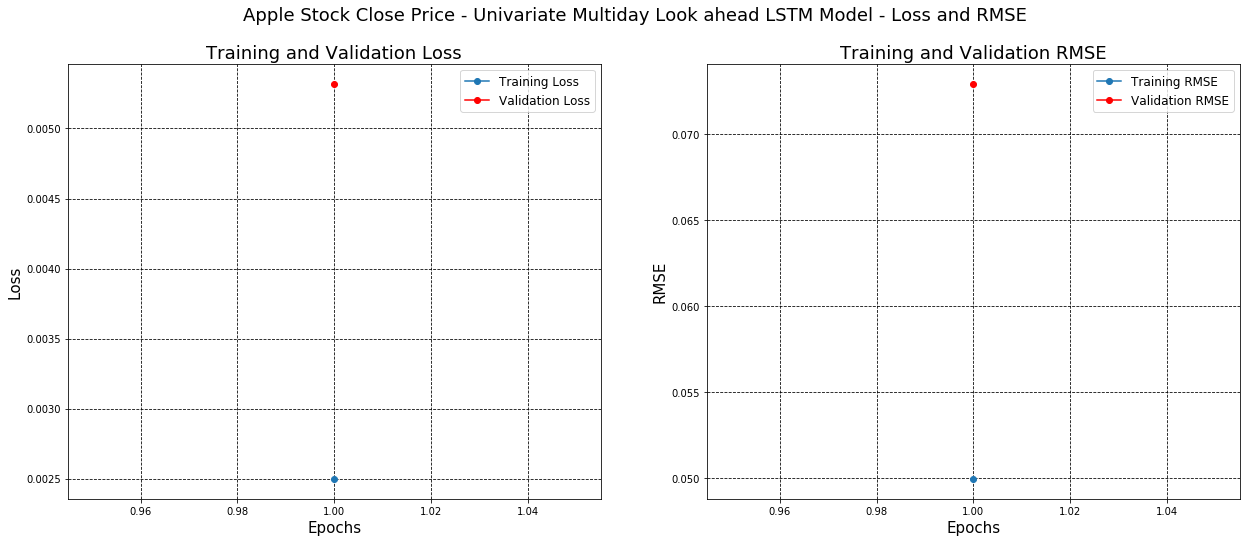

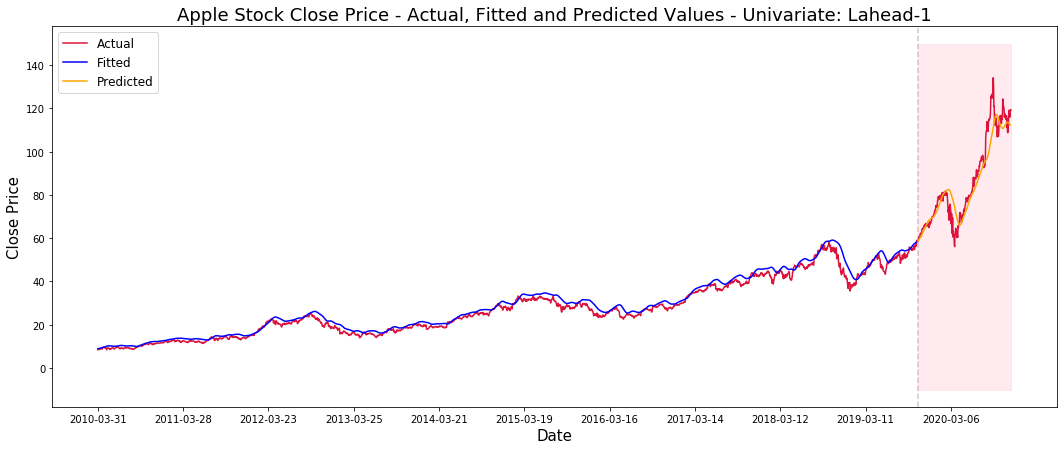

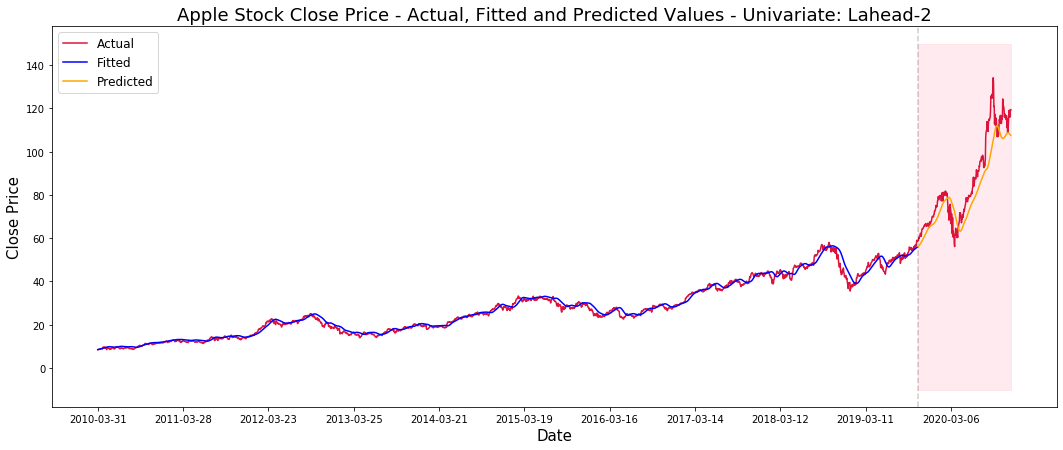

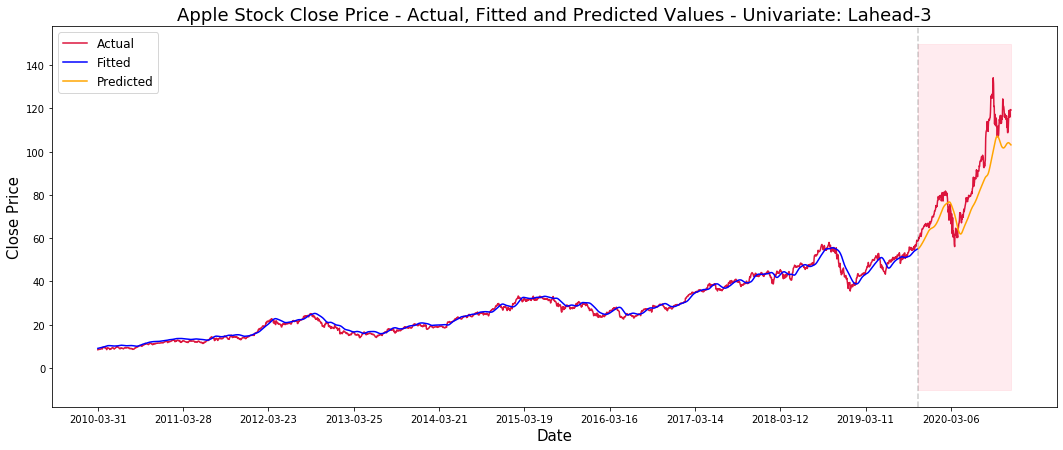

----------------------------------------------- Multivariate LSTM Model -------------------------------------------------

Total Size: 2737 Training Size: 2403 Test Size: 274
Training the model ...
Training completed!

Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_20 (CuDNNLSTM)    (None, 60, 150)           93600     
_________________________________________________________________
dropout_20 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_21 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________________________________________
dropout_21 (Dropout)         (None, 60, 150)           0         
_________________________________________________________________
cu_dnnlstm_22 (CuDNNLSTM)    (None, 60, 150)           181200    
_________________________________

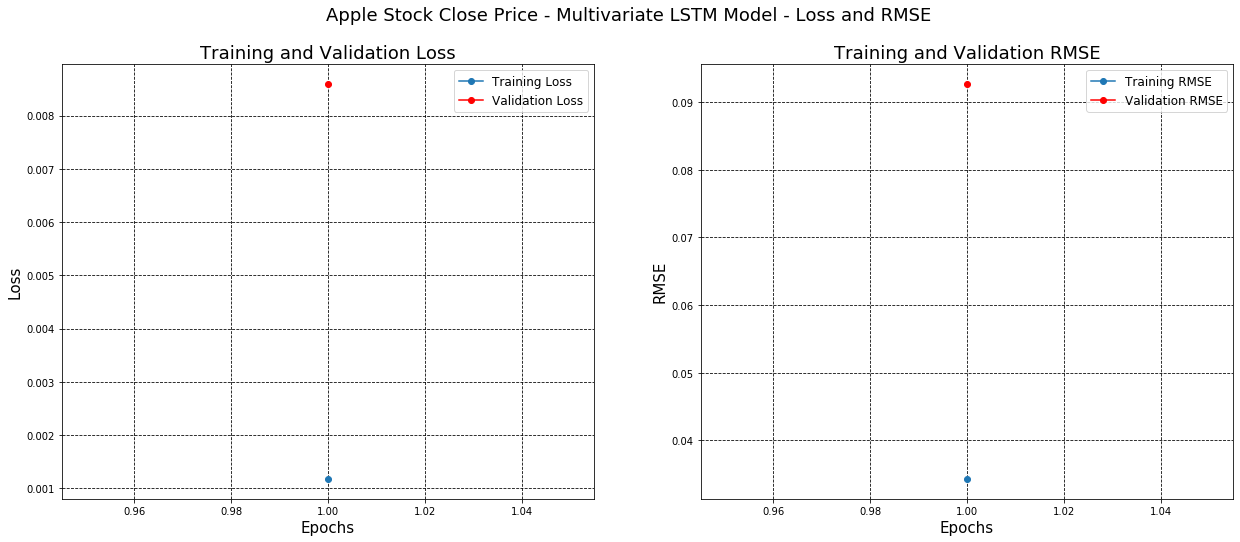

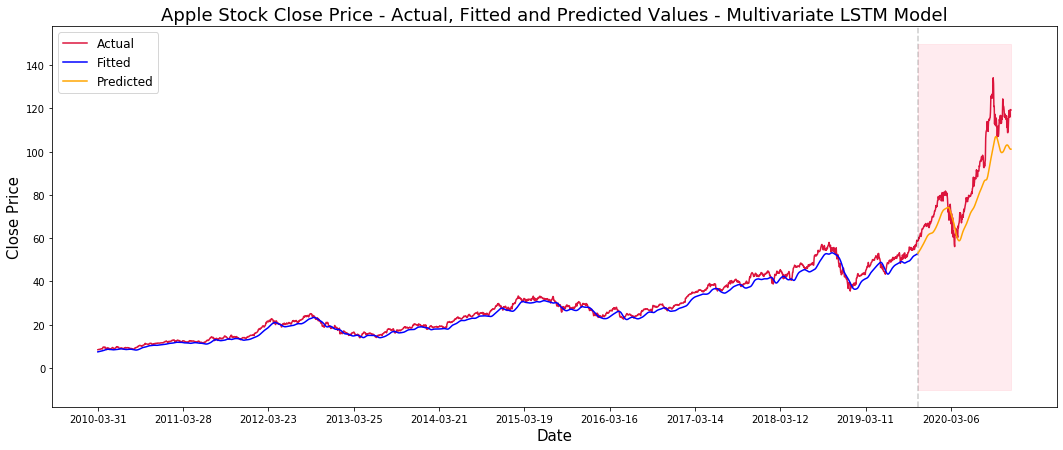


*************************************************** Processing Apple Stock ************************************************



In [50]:
# Dictionary to store the results of all the LSTM models
lstm_results = {}

# Number of past values to be used for prediction
window_size = 60

# Build and Predict Using all the LSTM Models
for security in dfs_price_scaled:
    header = header_prefix + security + header_suffix
    print(header)

    security_results = {}
    security_mse = mse_values[security]

    price = dfs_price[security]
    price_scaled = dfs_price_scaled[security]
    price_diff = dfs_price_diff[security]
    scaler = scalers[security]

    total_size = len(price)

    # Compute Training and Test Set Sizes
    total_training_size = int(total_size * training_percentage)
    training_size = total_training_size - window_size
    test_size = total_size - total_training_size

    # Print Training and Test Set Sizes
    print("LSTM Models: Total Size:", total_size, "Training Size:", training_size, "Test Size:", test_size)
    print('\n')
    
    model, dates, actual, predictions, mse = univariate_model(price_scaled, scaler, security, price_type)
    security_results[model] = dates, actual, predictions
    security_mse[model] = mse

    model, dates, actual, predictions, mse  = univariate_multiday_look_ahead_model(price_scaled, scaler, security, price_type)
    for i in range(1, len(model)):
        security_results[model[i]] = dates[:, i], actual[:, i], predictions[:, i]
        security_mse[model[i]] = mse[i]

    model, dates, actual, predictions, mse  = multivariate_model(price_scaled, scaler, security, price_type)
    security_results[model] = dates, actual, predictions
    security_mse[model] = mse

    lstm_results[security] = security_results
    
    footer = footer_prefix + security + footer_suffix
    print(header)    

### Display Price Prediction of all the LSTM Models

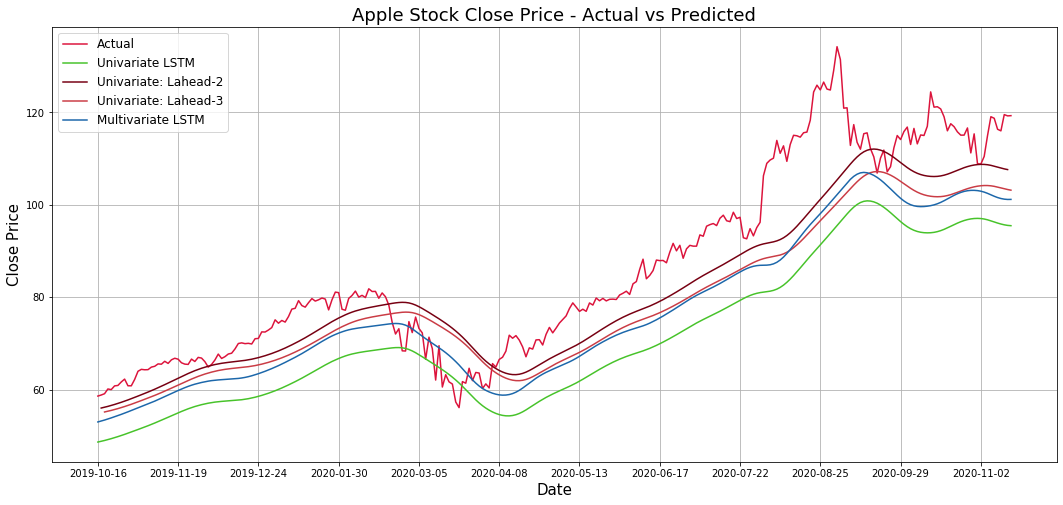

In [51]:
for security, security_results in lstm_results.items():
    actual_displayed = False

    plt.figure(figsize=(18, 8))
    for model, model_results in security_results.items():
        dates, actual, predictions = model_results
        model_list.append(model)
        if not actual_displayed:
            plt.plot(dates, actual, "-", color='crimson', label='Actual')
            actual_displayed = True

        plt.plot(dates, predictions, "-", color=np.random.rand(3,), label=model)

    plt.title(security + " " + price_type + " Price - Actual vs Predicted", fontsize=18)
    plt.xlabel("Date", fontsize=15)
    plt.ylabel(price_type + " Price", fontsize=15)
    plt.xticks(dates[::24])
    plt.legend(fontsize=12)
    plt.grid(True)
    plt.show();

# Performance Comparison of all the models

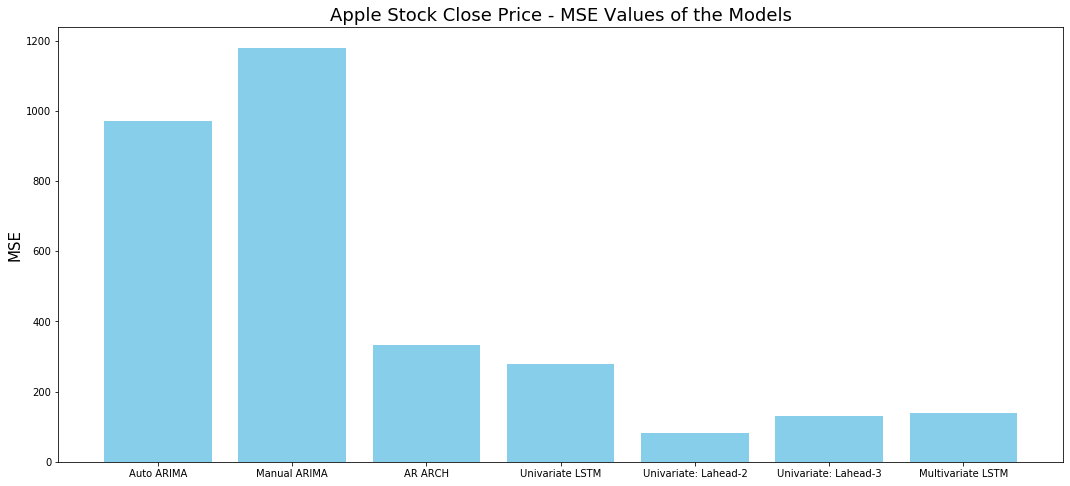

In [52]:
for security, security_results in mse_values.items():
    plt.figure(figsize=(18, 8))
    plt.bar(security_results.keys(), list(security_results.values()), color='skyblue')  
    plt.title(security + " " + price_type + " Price - MSE Values of the Models", fontsize=18)
    plt.ylabel("MSE", fontsize=15)
    plt.show();